
### План исследования:

1. [Открыть и просмотреть данные.](#step1)
2. [Провести исследовательский анализ данных EDA](#step2)
    - Есть ли в отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe())
    - Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())
    - Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
    - Постройте матрицу корреляций и отобразите её.
3. [Модель прогнозирования оттока клиентов](#step3)
    - Разбиение данных на валидационную и тренирововчную выборки train_test_split().
    - Обучение модели на линейной регрессии и случайном лесу. random_rate = 0 !
    - Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?
4. [Кластеризация](#step4)
    - Стандартизируйте данные.
    - Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
    - Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
    - Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
    - Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
    - Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?
5. [Общий вывод и рекомендации](#total)


In [1]:
# импортируем бибилиотеки
import os
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Отключаем предупреждения
register_matplotlib_converters()
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

In [2]:
# устанавливаем и обновляем пакеты
!pip install --upgrade --user pip
!pip install seaborn --upgrade --user
!pip install sklearn --upgrade --user
!pip install scipy --upgrade --user


<a id='step1'></a>
# Шаг 1 открыть данные и просмотреть.

In [3]:
# откроем датасет
try: #local path
    data = pd.read_csv('datas/gym_churn.csv')
except: #YaPract path
    data = pd.read_csv('/datasets/gym_churn.csv')


In [4]:
def check_data(data):
    """Функция просмотра данных info describe, проверка, пропусков и дубликатов"""
    duplicate_dict = {}
    isnull_dict = {}
    display(data.info(),'Типы данных таблицы',data.dtypes, data.describe())
    for value in data.columns:
        duplicate_dict[value] = data[value].duplicated().sum()
        isnull_dict[value] = data[value].isnull().sum()
        tmp_df = pd.DataFrame([isnull_dict])
    tmp_df.index = ['Пропусков в колонке']
    tmp_df = tmp_df.style.applymap(lambda x: 'color:darkred' if x > 0 else 'color:dark')
    display(tmp_df)
    print(f'Количество строк = {data.shape[0]}, количество столбцов = {data.shape[1]}\n')
    print('Всего строк дубликатов в таблице =', data.duplicated().sum())
    return data.head(10)

In [5]:
check_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

'Типы данных таблицы'

gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Пропусков в колонке,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Количество строк = 4000, количество столбцов = 14

Всего строк дубликатов в таблице = 0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [6]:
# сделаем все столбцы в нижнем регистре для удобства.
data.columns = [col.lower() for col in data.columns]
display(data.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

# Вывод после открытия и прсмотра данных:
1. Пропусков в данных не обнаружено.
2. Все типны данных в столбцах относятся к числовы int или float.
3. Дубликатов в таблице не обнаружено.

<a id = 'step2'></a>
# Шаг 2 EDA исследовательский анализ

In [7]:
# посмотрим на средние значения и стандартные отклонения
d = display # сокращаю для удобства
d(data.describe())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [8]:
flag = 1 if 'seo_empirex' in str(os.getlogin()) else 0 
# flag переменная для проверки и выставления значения меняющего цвет осей, тиков и названий
def show_distr(data, group_name, range_point):
    """Функция построения распределиний признаков,
        строит столбчатые диаграмы распределений group_name - параметр относительно которого строим распределение,
        range_point - это фактический диапозон group_name"""
    for col in data.drop(group_name, axis = 1):
        for value in range(range_point):
            graph = data[data[group_name] == value][col].plot(
                kind='hist', label=('{} {}'.format(group_name,value)))
            if flag: # local theme dark
                [attr(color = 'white') for attr in [plt.tick_params, plt.xticks, plt.yticks]]
                plt.title('Распределение ' + col, color = 'white')
            else: # yapra theme default
                [attr(color = 'black') for attr in [plt.tick_params, plt.xticks, plt.yticks]]
                plt.title('Распределение ' + col, color = 'black')
            graph.legend()
        plt.show()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
остался,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
ушел,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


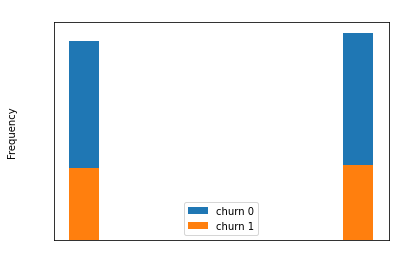

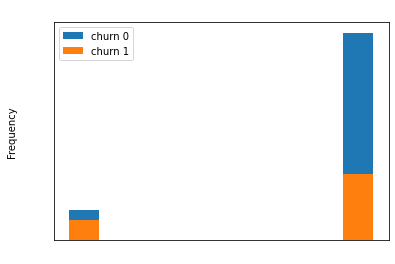

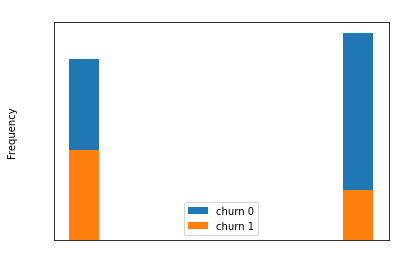

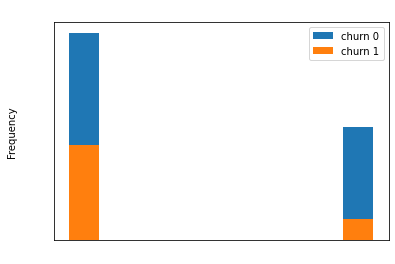

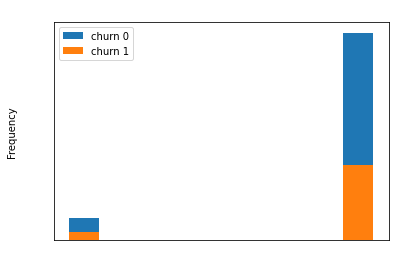

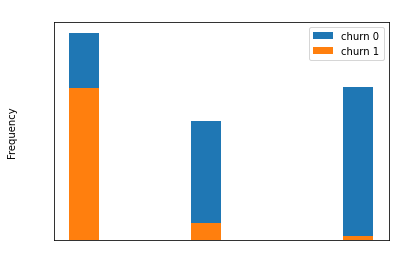

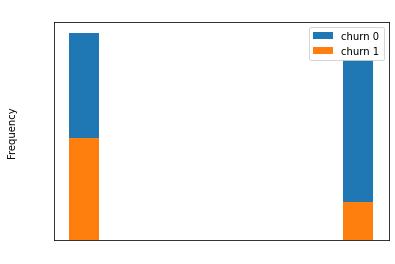

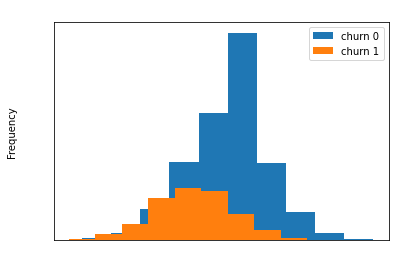

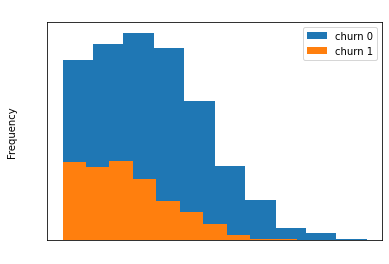

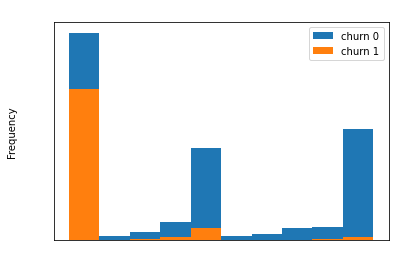

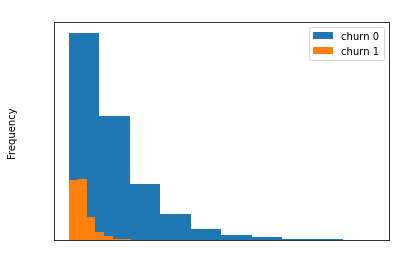

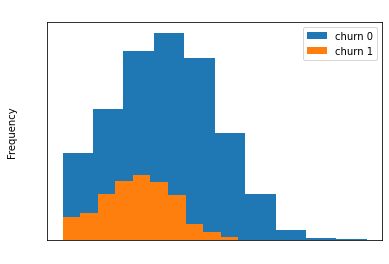

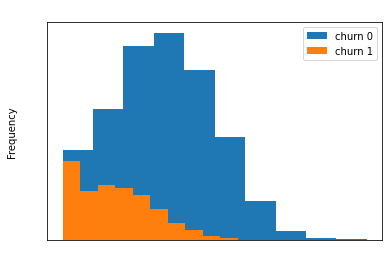

In [9]:
# срупируем по тем кто ушел и тем кто остался посмотрим среднее, дропнуть churn чтобы не задвоился
gr_by_churn_mean = data.groupby('churn').agg({
    key:'mean' for key in data.columns}).drop('churn', axis = 1)
gr_by_churn_mean.index = ['остался', 'ушел']
d(gr_by_churn_mean)

show_distr(data, 'churn', 2)

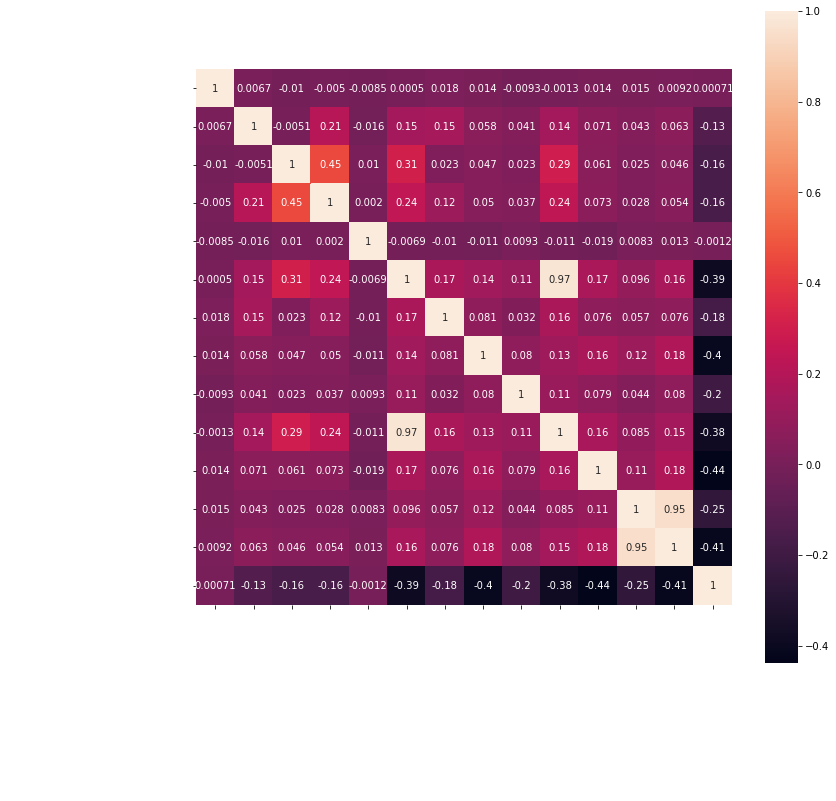

In [10]:
# построим тепловую матрицу корреляций
corr_matrix = data.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr_matrix, annot = True, square = True)
if flag: # белый цвет осей
    plt.title('Матрица корреляционных зависимостей', color = 'white')
    plt.xticks(color = 'white')
    plt.yticks(color = 'white')
else: # черный цвет по умолчанию
    plt.title('Матрица корреляционных зависимостей', color = 'black')
    plt.xticks(color = 'black')
    plt.yticks(color = 'black')    
plt.show()

# Удалим мултиколинеарный признак contract_period

data = data.drop('contract_period', axis = 1)

# Выводы после EDA
1. **"Портрет среднего клиента"** - Пол 50/50 парни и девушки, примерно половина это корпоративные клиенты, большая часть живет рядом, половина клиентов пришли по "сарафану" приведи друга, почти  все оставляют свой телефон, текущие абонементы в среднем на 6 месяцев, чуть меньше половины посещают груповые занятия, оно и логично если половина девушки, то они часто посещают группы нежели парни,  возраст клиентов в среднем 29 лет, среднее время которое прошло с момента их первого визита это 4-5 месяцев.

2. Переменные Age, avg_additional_charges_total необходимо будет стандартиировать 

3. Количественоо тех кто остался больше чем тех кто оттек из фитнесс клуба. По каждому из графиков это хорошо видно. Около 1/4 клиентов уходят.

4. Матрица корреляцонных завсимостей
    - Наибольшая зависимость более 0.9 наблюдается между признаками Avg_class_frequency_current_month и Avg_class_frequency_total. средняя частота посещений в неделю за все время с начала действия абонемента и  средняя частота посещений в неделю за предыдущий месяц сильно коррелируют, так как если человек с начала своего абонемента часто посещает, то из месяца в месяц продолжит это делать, мотивации не занимать у этих людей!
    - promo_friends и partner, обладают хорошей зависимостью 0.45 сарафан приведи други и корпоративный клиент очень связаны, сотрудник может привлечь другого, или сама компания может привести еще одну компанию. 
    - необходимо обратить внимание на month_to_end_contract и contract_period зависимость есть сильная 0.97! длительность абонемента и срок до окончания очень сильно коррелируют между собой. 

*необходимо удалить один признак из пары мультиколинеарных* это month_to_end_contract или contract_period.

<a id = 'step3'></a>
# Шаг 3 модель прогнозирования оттока

Разбиение данных на валидационную и тренирововчную выборки train_test_split().

Обучение модели на логистической регрессией и случайным лесом random_rate = 0 !

Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [11]:
# Выделим признаки и целевую переменную
# Разобьем данные на валидационную выборку и тренироваочную с помощью train_test_split()
X = data.drop('churn', axis = 1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

# Для модели линейной регрессии необхдимо станлартизировать данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


In [12]:
def learn_and_print_metrics(model, x_train_st, x_test_st, y_train, y_test):
    """Функция запускает обучение модели и выводит метрики [accuracy_score,
                                                    precision_score,
                                                    recall_score,
                                                    f1_score,
                                                    roc_auc_score] после обучения.
        Также функция выводит название модели"""
    print(model.__class__.__name__)
    model.fit(x_train_st, y_train)
    df_metrics = {}
    predictions = model.predict(x_test_st)
    try:
        probabilities = model.predict_proba(x_test_st)[:,1]
        df_metrics[roc_auc_score.__name__] = '{:.2f}'.format(roc_auc_score(y_test, probabilities))
    except AttributeError:
        print('Wrong atribute!')
    for metric in [accuracy_score, precision_score,recall_score,f1_score]:
            df_metrics[metric.__name__] = '{:.2f}'.format(metric(y_test, predictions))
    d(pd.DataFrame([df_metrics]))
    return '{} Finished'.format(model.__class__.__name__)

In [13]:
# Возьмем модель логистической регрессии и случайного леса, чтобы не удалять в ручную сильно коррелирующие признаки
reg_line_model = LogisticRegression(solver='liblinear')
rnd_forest_model = RandomForestClassifier(n_estimators=100, random_state = 0)

for model in [reg_line_model, rnd_forest_model]:
    learn_and_print_metrics(model, X_train_st, X_test_st, y_train, y_test)

LogisticRegression


,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
0,0.98,0.94,0.90,0.86,0.88


RandomForestClassifier


,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
0,0.97,0.93,0.90,0.83,0.86


# Выводы после выбора модели прогнозирования оттока

1. На выбор были предложены 2 модели это  LogisticRegression и RandomForestClassifier.
2. Перед использованием моделей была проведена стандартизация данных, и разделение выборки 80/20 тренировочную и валидационную
3. Лучшим образом себя показала Логистическая регрессия LogisticRegression, так как ее параметры precision_score и recall_score выше чем у рандомного лесного классификатора.

<a id = 'step4'></a>
# Шаг 4 Кластеризация и K-means

- Стандартизируйте данные.
- Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
- Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [20]:
# Стандартизируем датасет с признаками
# Построим матрицу расстояний функцией linkage()
data_drop_churn = data.drop('churn', axis = 1)
std_df = scaler.fit_transform(data_drop_churn)
linked = linkage(std_df, method = 'ward')
#plt.figure(figsize=(15, 10))
#dendrogram(linked, orientation='top')
#plt.show()

# построение дендро граммы процесс длительный, раскоментировать при необходимости.

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,
0,0.485597,0.992798,0.940329,0.912551,1.00000,0.536008,29.612140,154.221687,7.080247,4.432099,1.868932,1.827433
1,0.524675,0.862338,0.472727,0.306494,0.00000,0.425974,29.283117,144.240418,4.457143,3.922078,1.846575,1.716160
2,0.560428,0.973262,0.309091,0.083422,0.99893,0.485561,30.270588,165.107405,4.655615,4.989305,2.837277,2.836336
3,0.493186,1.000000,0.257240,0.094549,1.00000,0.330494,28.210392,132.180078,2.480409,2.437819,1.226093,1.001368
4,0.494382,0.000000,0.486891,0.074906,1.00000,0.228464,28.573034,136.299693,2.674157,2.910112,1.678385,1.504945


,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,
0,972,972,972,972,972,972,972,972,972,972,972,972
1,385,385,385,385,385,385,385,385,385,385,385,385
2,935,935,935,935,935,935,935,935,935,935,935,935
3,1174,1174,1174,1174,1174,1174,1174,1174,1174,1174,1174,1174
4,534,534,534,534,534,534,534,534,534,534,534,534


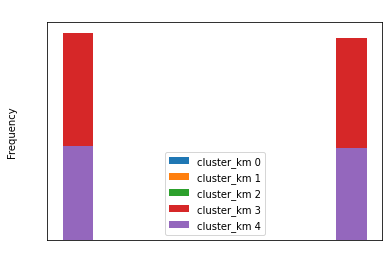

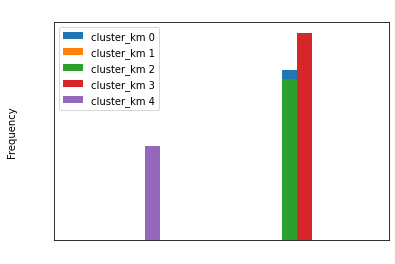

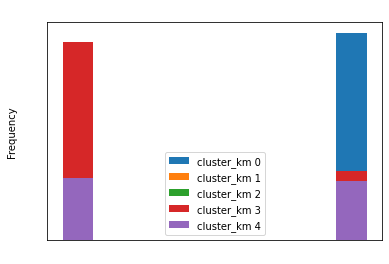

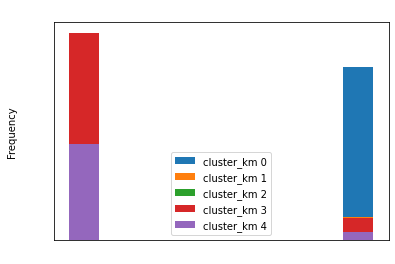

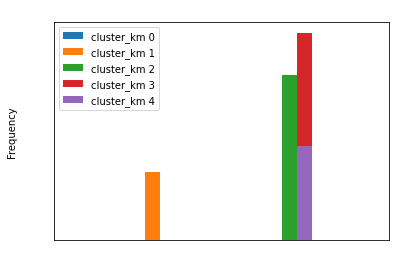

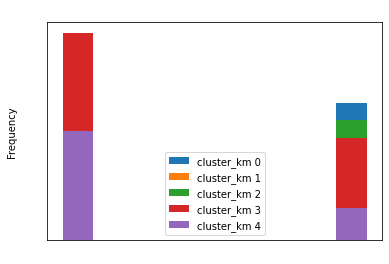

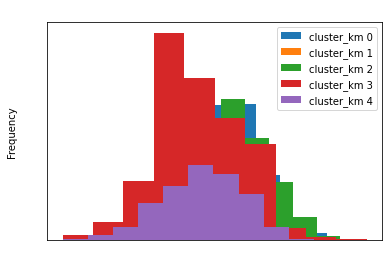

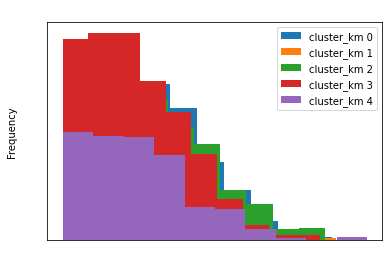

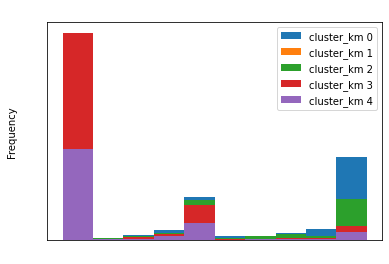

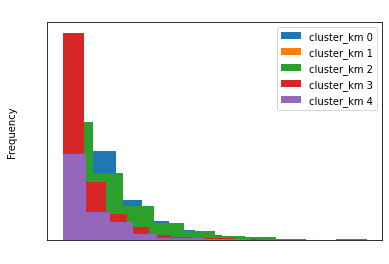

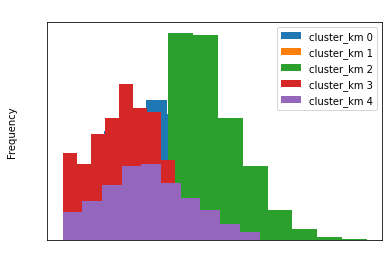

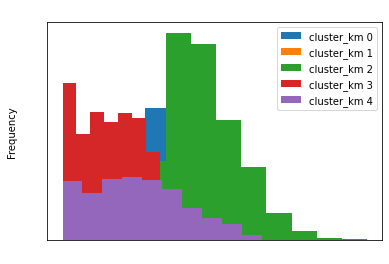

In [16]:
# Обучим модель кластеризации K-Means примем число кластеров за 5
km_model = KMeans(n_clusters = 5, random_state = 0)
labels = km_model.fit_predict(std_df)
data_drop_churn['cluster_km'] = labels

#посмторим на средние значения для признаков 
d(data_drop_churn.groupby('cluster_km').mean())


cluster_count = data_drop_churn.groupby('cluster_km').count()
d(cluster_count)


show_distr(data_drop_churn, 'cluster_km', 5)

In [17]:
# Напишем функцию для анализа кластеров
def show_means_and_scatter(data, x, y, cluster):
    """Функуция показывает средние значения признаков по сгруппированному кластеру
    также рисует график scatter между двумя признаками"""
    print(f'таблица средниx {x} & {y}')
    group = data.groupby(cluster).agg({x:'mean', y:'mean'})
    d(group)
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data[x], data[y], hue=data[cluster],palette='Paired')
    if flag:
        plt.title('{} and {}'.format(x, y), color = 'white')
        plt.xticks(color = 'white')
        plt.yticks(color = 'white')
    else: # черный цвет по умолчанию
        plt.title('{} and {}'.format(x, y), color = 'black')
        plt.xticks(color = 'black')
        plt.yticks(color = 'black')    
    plt.show()
    return f'{x} VS {y} finished'


Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Поэтому для сравинтельного анализа возьмем следующие колонки

Avg_class_frequency_total,
Avg_class_frequency_current_month,
Avg_additional_charges_total

таблица средниx avg_class_frequency_total & avg_class_frequency_current_month


,avg_class_frequency_total,avg_class_frequency_current_month
cluster_km,,
0,1.868932,1.827433
1,1.846575,1.716160
2,2.837277,2.836336
3,1.226093,1.001368
4,1.678385,1.504945


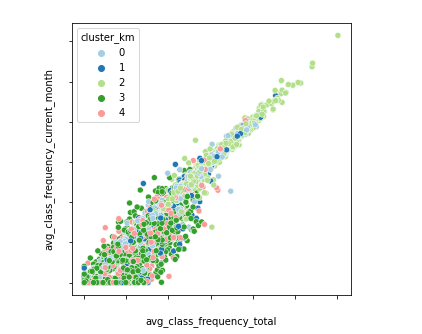

таблица средниx avg_class_frequency_current_month & avg_additional_charges_total


,avg_class_frequency_current_month,avg_additional_charges_total
cluster_km,,
0,1.827433,154.221687
1,1.716160,144.240418
2,2.836336,165.107405
3,1.001368,132.180078
4,1.504945,136.299693


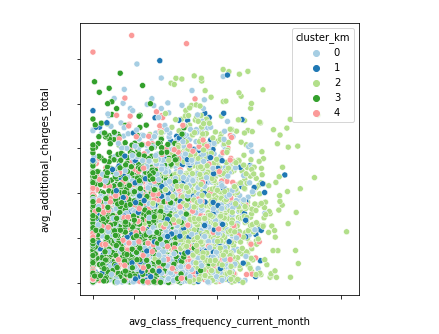

In [18]:
list_cols = ['avg_class_frequency_total', 
             'avg_class_frequency_current_month',
                'avg_additional_charges_total']

# напишем цикл для автоматизации
for i in range(len(list_cols) - 1):
    curr = list_cols[i]
    next_col = list_cols[i + 1]
    show_means_and_scatter(data_drop_churn, curr, next_col, 'cluster_km')

In [19]:
# Сделаем групировку по кластерам и посчитаем средний отток и сделаем таблицу более презентабельной

total = pd.merge(data, data_drop_churn, on = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits', 'age', 'avg_additional_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
       'avg_class_frequency_current_month'])


group_by_cluster = total.groupby(['cluster_km']).agg({
    'churn':'mean'
})
d(group_by_cluster)
d(data_drop_churn.groupby('cluster_km').mean())


,churn
cluster_km,
0,0.103909
1,0.267532
2,0.048128
3,0.500852
4,0.419476


,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,
0,0.485597,0.992798,0.940329,0.912551,1.00000,0.536008,29.612140,154.221687,7.080247,4.432099,1.868932,1.827433
1,0.524675,0.862338,0.472727,0.306494,0.00000,0.425974,29.283117,144.240418,4.457143,3.922078,1.846575,1.716160
2,0.560428,0.973262,0.309091,0.083422,0.99893,0.485561,30.270588,165.107405,4.655615,4.989305,2.837277,2.836336
3,0.493186,1.000000,0.257240,0.094549,1.00000,0.330494,28.210392,132.180078,2.480409,2.437819,1.226093,1.001368
4,0.494382,0.000000,0.486891,0.074906,1.00000,0.228464,28.573034,136.299693,2.674157,2.910112,1.678385,1.504945


# Выводы после кластеризации

1. Были взяты 5 кластеров для обучения модели.
2. Согласно средним показателям кластеры можно описать следущим образом:
    - Разделение на кластеры прошло в целом удачно в каждой группе примерно равное количество половых признаков.
    - Корпоративные клиенты были отнесены преимущественно во второй кластер.
    - В нулевом кластере скопились люди не оставившие телефон.
    - Возраст в среднем в кластерах близкий.
3. Можно составить следующие профили по кластерам:
    - 0 КЛАСТЕР Средний возраст 29 лет, пол 50/50, в основном те кто живет не подалеку , преимущественно корпоративные клиенты, приглашенные друзьями, ходят к нам уже 4 месяца абонементы приобретают на 7 и более месяцев менее подвержены оттоку. Абонементы скорее всего купила им организация на год.
    - 1 КЛАСТЕР Средний возраст 29, больше парней чем девушек, живут недалеко, не кормпоративные клиенты и не пришли по программе для друзей, скорее всего жители данного района, которые еще и не любят оставлять телефоны, абонементы приобретают на 6 месяцев, половина ходит на груповые занятия.
    - 2 КЛАСТЕР Самый мотивированный кластер, средний возраст 30 лет, живут не подалеку, посещают с завидно регулярностью, не корпоративные, средний чек внутри фитнес центра самый высокий. Наименее вероятный отток.
    - 3 КЛАСТЕР  Живут рядом, форзраст 28 лет, слабо мотивированные, не участники программы приведи друга и компании не купили им аббонемент, средних визитов за последний месяц не более 1
    - 4 КЛАСТЕР Не живут рядом, посещают редко, средний возраст 28, не любят групповые тринировки
2. Для сравнения на графике были выбраны  'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон. Потому что клиент наиболее часто попадает в отток если не посещал редко за последний месяц или не посещал вообще.
3. Графики распределения признаков из пункта выше показывают, что частота посещений в неделю и за все время с начала дейсвтия абонемент сильно пересекаются в кластерах. 2 и 0 класетры.
4. Графики распределения сумарной выручки и средней частоты посещений показали также сильную пересекаемость кдастеров 2 и 0.

*Пора делать общие выводы по исследованию*

<a id='total'></a>

# Общие выводы по исследованию оттока финтесс центра

## 1 Этап после открытия данных

1. Пропусков в данных не обнаружено.
2. Все типны данных в столбцах относятся к числовы int или float.
3. Дубликатов в таблице не обнаружено.

## 2 Этап EDA

1. **"Портрет среднего клиента"** - Пол 50/50 парни и девушки, примерно половина это корпоративные клиенты, большая часть живет рядом, половина клиентов пришли по "сарафану" приведи друга, почти  все оставляют свой телефон, текущие абонементы в среднем на 6 месяцев, чуть меньше половины посещают груповые занятия, оно и логично если половина девушки, то они часто посещают группы нежели парни,  возраст клиентов в среднем 29 лет, среднее время которое прошло с момента их первого визита это 4-5 месяцев.

2. Переменные Age, avg_additional_charges_total необходимо будет стандартиировать 

3. Количественоо тех кто остался больше чем тех кто оттек из фитнесс клуба. По каждому из графиков это хорошо видно. Около 1/4 клиентов уходят.

4. Матрица корреляцонных завсимостей 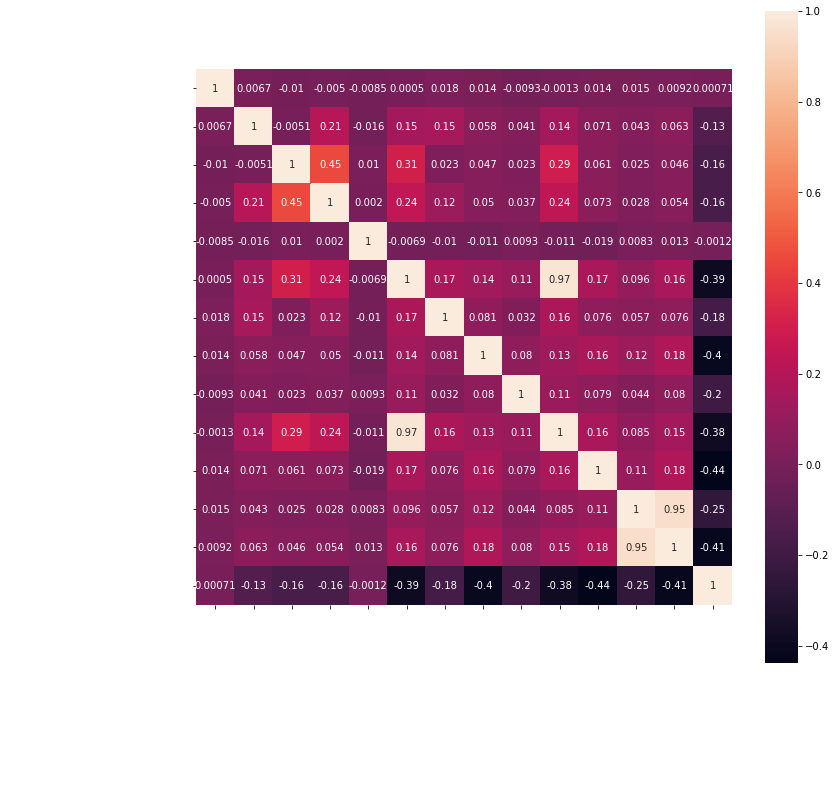
    - Наибольшая зависимость более 0.9 наблюдается между признаками Avg_class_frequency_current_month и Avg_class_frequency_total. средняя частота посещений в неделю за все время с начала действия абонемента и  средняя частота посещений в неделю за предыдущий месяц сильно коррелируют, так как если человек с начала своего абонемента часто посещает, то из месяца в месяц продолжит это делать, мотивации не занимать у этих людей!
    - promo_friends и partner, обладают хорошей зависимостью 0.45 сарафан приведи други и корпоративный клиент очень связаны, сотрудник может привлечь другого, или сама компания может привести еще одну компанию. 
    - необходимо обратить внимание на month_to_end_contract и contract_period зависимость есть сильная 0.97! длительность абонемента и срок до окончания очень сильно коррелируют между собой. 

*необходимо удалить один признак из пары мультиколинеарных* это month_to_end_contract или contract_period. 

## 3 Этап

1. На выбор были предложены 2 модели это  LogisticRegression и RandomForestClassifier.
2. Перед использованием моделей была проведена стандартизация данных, и разделение выборки 80/20 тренировочную и валидационную
3. Лучшим образом себя показала Логистическая регрессия LogisticRegression, так как ее параметры precision_score и recall_score выше чем у рандомного лесного классификатора.

## 4 Этап

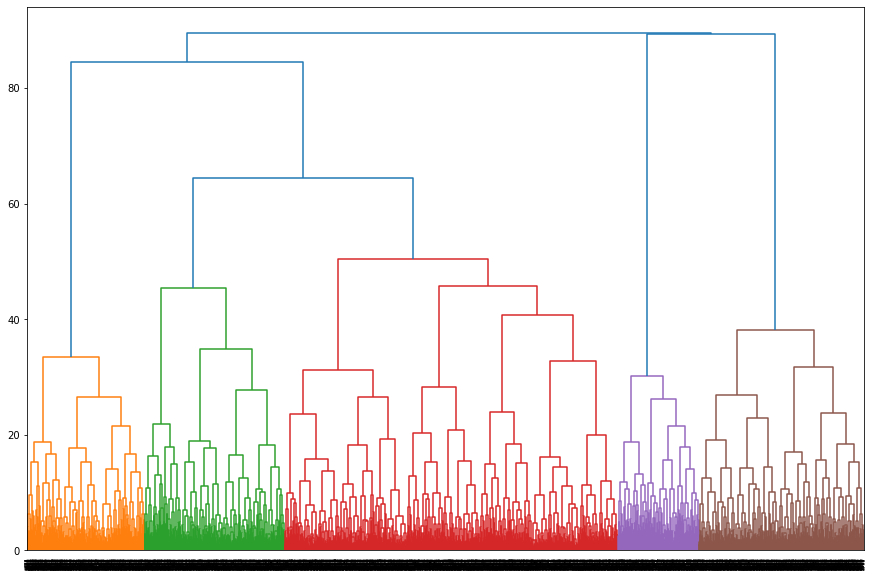

1. Были взяты 5 кластеров для обучения модели.
2. Согласно средним показателям кластеры можно описать следущим образом:
    - Разделение на кластеры прошло в целом удачно в каждой группе примерно равное количество половых признаков.
    - Корпоративные клиенты были отнесены преимущественно во второй кластер.
    - В нулевом кластере скопились люди не оставившие телефон.
    - Возраст в среднем в кластерах близкий.
3. Можно составить следующие профили по кластерам:
    - 0 КЛАСТЕР Средний возраст 29 лет, пол 50/50, в основном те кто живет не подалеку , преимущественно корпоративные клиенты, приглашенные друзьями, ходят к нам уже 4 месяца абонементы приобретают на 7 и более месяцев менее подвержены оттоку. Абонементы скорее всего купила им организация на год.
    - 1 КЛАСТЕР Средний возраст 29, больше парней чем девушек, живут недалеко, не кормпоративные клиенты и не пришли по программе для друзей, скорее всего жители данного района, которые еще и не любят оставлять телефоны, абонементы приобретают на 6 месяцев, половина ходит на груповые занятия.
    - 2 КЛАСТЕР Самый мотивированный кластер, средний возраст 30 лет, живут не подалеку, посещают с завидно регулярностью, не корпоративные, средний чек внутри фитнес центра самый высокий. Наименее вероятный отток.
    - 3 КЛАСТЕР  Живут рядом, форзраст 28 лет, слабо мотивированные, не участники программы приведи друга и компании не купили им аббонемент, средних визитов за последний месяц не более 1
    - 4 КЛАСТЕР Не живут рядом, посещают редко, средний возраст 28, не любят групповые тринировки
2. Для сравнения на графике были выбраны  'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон. Потому что клиент наиболее часто попадает в отток если не посещал редко за последний месяц или не посещал вообще.
3. Графики распределения признаков из пункта выше показывают, что частота посещений в неделю и за все время с начала дейсвтия абонемент сильно пересекаются в кластерах. 2 и 0 класетры.
4. Графики распределения сумарной выручки и средней частоты посещений показали также сильную пересекаемость кдастеров 2 и 0.
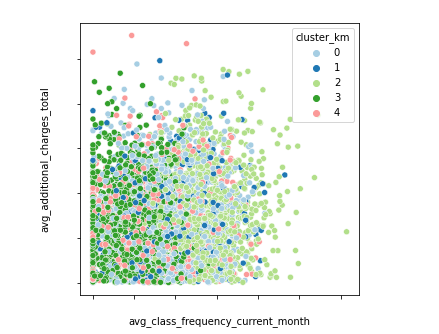
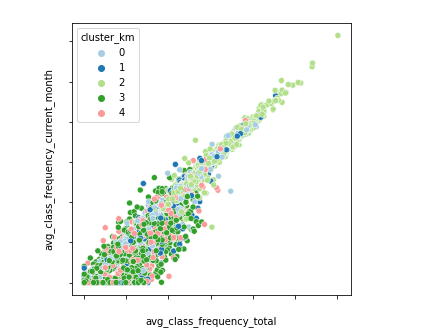

### Рекомендация аналитика

**Как видно на таблице внизу, наибольший склонны к оттоку в кластерах 3,4,1. Для этих клиентов можно выбрать разные стратегии удержания, подарить им сертификат на массаж при покупке абонемента на следующий месяц, можно проинформировать их смс уведомлением о том что им пора бы вернуться в спорт-зал. Можно запустить акцию "при покупке абонемента на 12 месяцев составление программы тренировок на весь год с питанием!". Следует обзвонить этих людей и понять причины их редкой посещаемости, чтобы сформировать более качественное предложение или разработать новые программы для тренировок. Наиболее перспективные кластеры это 2 и 1 для этих людей тоже необходимо разработать стратегию, у них достаточно мотивации чтобы ходить, можно сделать им подарки и увеличить бонус за приведенного друга!**

    churn   cluster_km	
        0	0.103909
        1	0.267532
        2	0.048128
        3	0.500852
        4	0.419476